In [1]:
import numpy as np
import pandas as pd
import mrmr
import shap
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix,classification_report, f1_score,  recall_score,
                             roc_auc_score, balanced_accuracy_score,accuracy_score)
from sklearn.model_selection import StratifiedKFold,cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time
import pickle
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('hotel_reservations.csv')

In [3]:
df.shape

(119390, 32)

In [4]:
df.drop(columns=['agent','company'],inplace=True)
df.dropna(inplace=True)

In [5]:
df.drop(columns=['arrival_date_week_number','arrival_date_day_of_month','arrival_date_year','reservation_status','reservation_status_date'], inplace=True)

In [6]:
df['meal'].replace('Undefined','SC', inplace=True)

In [7]:
df.drop(columns=['distribution_channel','assigned_room_type'], inplace=True)

In [8]:
df['is_canceled'].value_counts()/df.shape[0]

0    0.628648
1    0.371352
Name: is_canceled, dtype: float64

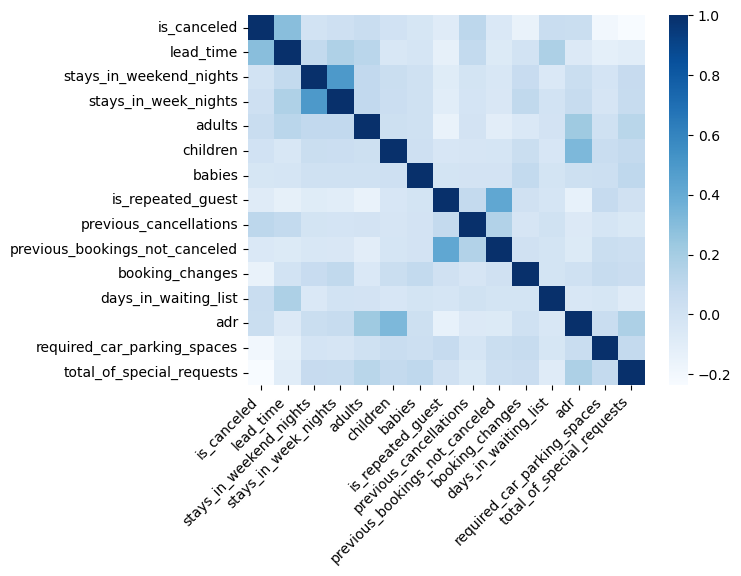

In [9]:
sns.heatmap(df.corr(),cmap='Blues')
plt.xticks(rotation=45, ha='right');
plt.savefig('figure1.png', transparent=True,bbox_inches='tight') # save as png

In [10]:
# df = df.sample(1000, random_state=42)

In [11]:
df = pd.get_dummies(df,columns=['is_repeated_guest','hotel'], drop_first=True)

In [12]:
df = pd.get_dummies(df)

In [13]:
X= df.drop(columns='is_canceled')
y= df['is_canceled']

In [14]:
X.shape

(118898, 232)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,  random_state=42)

**Scaler**

In [16]:
scaler = StandardScaler()

In [17]:
X_train_sc = scaler.fit_transform(X_train)

In [18]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

In [19]:
X_test_sc = scaler.transform(X_test)

In [20]:
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

**Shap**

In [21]:
lgb = LGBMClassifier(random_state=42)

In [22]:
lgb.fit(X_train_sc,y_train)

LGBMClassifier(random_state=42)

In [23]:
shap_values = shap.TreeExplainer(lgb).shap_values(X_train_sc, approximate=False)
shap_values[1]
shap_df = pd.DataFrame(shap_values[1])
shap_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231
0,-1.364003,-0.020512,0.018253,0.019025,-0.004447,-0.000672,-0.113718,0.022875,-0.683930,0.009526,0.188628,0.311531,0.233677,-0.039977,-0.103013,-0.004485,0.000099,0.000998,-0.002784,-0.002274,0.008733,-0.008341,-0.000740,-0.005240,-0.002075,-0.019452,0.002741,0.002451,0.000612,0.000318,-0.010883,0.0,-0.003520,0.0,0.0,0.0,-0.001032,0.0,0.0,0.0,0.0,0.0,0.0,0.001052,0.0,0.0,0.005169,0.0,0.0,0.0,0.000186,0.0,0.0,0.0,0.0,0.0,-0.002221,0.0,0.0,0.0,0.000404,0.0,-0.002614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013638,0.0,0.0,0.000411,0.0,0.0,0.0,0.0,-0.006204,0.0,0.0,0.001284,0.0,0.012256,0.0,0.0,0.007565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000272,0.0,0.0,0.0,-0.000334,0.0,0.0,0.002777,0.0,0.0,0.0,-0.000625,-0.009429,0.0,0.0,0.0,0.000695,0.0,0.0,0.0,0.0,0.0,-0.000169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000636,0.0,0.0,-0.001243,0.0,0.0,0.0,0.000087,0.0,0.0,0.0,0.0,0.0,-0.000066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000216,0.0,0.002556,0.000956,0.0,0.000694,0.0,0.0,0.0,0.0,-0.000218,0.0,0.0,0.0,-0.535311,0.0,0.0,0.0,0.0,-0.001930,0.0,-0.000418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000135,0.000131,0.0,0.0,0.0,-0.000045,0.0,0.0,-0.000064,-0.000079,0.0,0.0,0.0,-0.000237,0.0,0.0,-0.000268,0.0,0.0,0.0,0.0,-0.000279,0.0,0.0,-0.001967,0.000235,0.001373,0.407519,0.004687,0.013393,-0.553208,0.012715,-0.002864,-0.001427,0.000120,-0.000615,0.002165,-0.016125,0.0,0.0,0.0,-0.202516,-0.808113,0.0,0.010976,0.0,0.040387,0.037389
1,-1.966220,0.117999,-0.107118,-0.065516,-0.003209,-0.000077,-0.117132,0.030656,-0.686246,0.008085,-0.132866,0.359411,0.269022,-0.020631,-0.025840,-0.007365,-0.002807,0.001852,-0.005836,-0.002569,0.011399,0.003957,-0.000974,-0.004696,-0.003350,-0.035014,0.009958,0.014428,0.000653,0.006630,-0.004145,0.0,-0.003994,0.0,0.0,0.0,-0.000985,0.0,0.0,0.0,0.0,0.0,0.0,0.000857,0.0,0.0,0.005033,0.0,0.0,0.0,0.000192,0.0,0.0,0.0,0.0,0.0,-0.003688,0.0,0.0,0.0,0.001760,0.0,-0.003665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014634,0.0,0.0,0.000418,0.0,0.0,0.0,0.0,-0.005018,0.0,0.0,0.001016,0.0,0.014689,0.0,0.0,0.014552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000263,0.0,0.0,0.0,-0.000337,0.0,0.0,0.003017,0.0,0.0,0.0,-0.000517,-0.007479,0.0,0.0,0.0,0.000831,0.0,0.0,0.0,0.0,0.0,-0.000137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000621,0.0,0.0,-0.001200,0.0,0.0,0.0,0.000087,0.0,0.0,0.0,0.0,0.0,-0.000067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000215,0.0,0.003107,0.001260,0.0,0.000718,0.0,0.0,0.0,0.0,-0.000220,0.0,0.0,0.0,0.552475,0.0,0.0,0.0,0.0,-0.001811,0.0,-0.000350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000103,0.000119,0.0,0.0,0.0,-0.000045,0.0,0.0,-0.000064,-0.000892,0.0,0.0,0.0,-0.000237,0.0,0.0,0.000377,0.0,0.0,0.0,0.0,-0.000282,0.0,0.0,-0.002055,0.000680,0.002049,-0.025627,-0.004792,-0.017543,0.239724,-0.007314,-0.000446,-0.000196,-0.000022,0.001225,0.003105,-0.000911,0.0,0.0,0.0,-0.199029,-0.742295,0.0,0.002669,0.0,0.049004,0.004173
2,0.607392,-0.046270,-0.021538,0.022196,-0.001877,-0.000088,-0.147392,0.031790,0.092298,-0.005760,-0.216444,0.243058,0.311640,0.004629,-0.073669,0.017475,0.000632,-0.007833,-0.004621,-0.001584,0.014910,-0.003751,0.000334,0.000830,-0.005740,0.001971,0.007396,0.012571,0.000154,0.016311,0.002827,0.0,-0.001959,

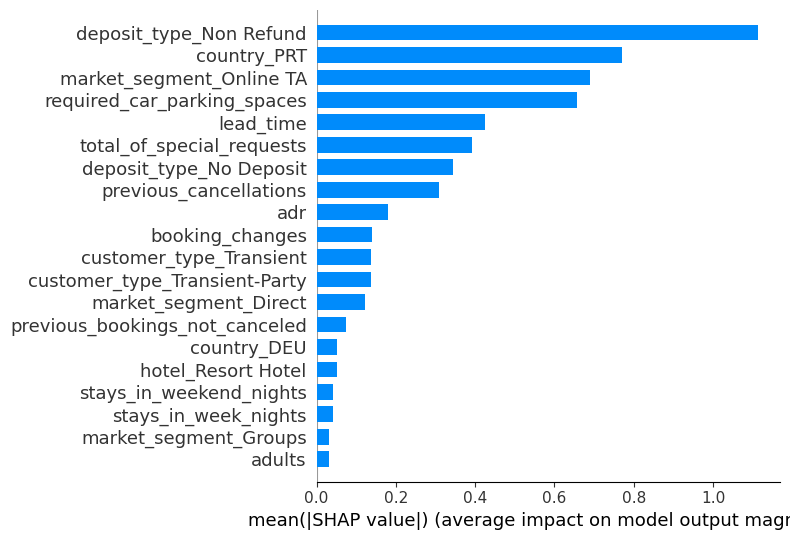

In [24]:
shap_plot = shap.summary_plot(shap_df, X_train, plot_type="bar", max_display=20, plot_size=0.2, cmap='Blues')
#plt.savefig('figure1.png', transparent=True,bbox_inches='tight') # save as png

In [25]:
# explainer = shap.TreeExplainer(lgb, X_train_sc)
# shap_values_rfc = explainer(X_train_sc, check_additivity=False)
# shap_values_rfc_pos = shap_values_rfc[..., 1]
# shap.plots.beeswarm(shap_values_rfc_pos, max_display=None)

In [26]:
# shap_values_rfc[...,1]
# shap.plots.waterfall(shap_values_rfc_pos[0], max_display=15)

In [27]:
# shap_values_rfc_pos[0]

**MRMR**

In [28]:
selected_cols = mrmr.mrmr_classif(pd.DataFrame(X_train_sc, columns = X.columns), y_train.values, K=150)
selected_cols

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:45<00:00,  3.28it/s]


['deposit_type_Non Refund',
 'required_car_parking_spaces',
 'country_PRT',
 'deposit_type_No Deposit',
 'lead_time',
 'total_of_special_requests',
 'booking_changes',
 'market_segment_Direct',
 'market_segment_Groups',
 'country_FRA',
 'country_DEU',
 'previous_cancellations',
 'country_GBR',
 'customer_type_Transient',
 'hotel_Resort Hotel',
 'is_repeated_guest_1',
 'customer_type_Transient-Party',
 'country_ARE',
 'market_segment_Corporate',
 'country_BEL',
 'country_NLD',
 'country_ESP',
 'country_AUT',
 'customer_type_Group',
 'arrival_date_month_March',
 'country_CN',
 'days_in_waiting_list',
 'adults',
 'country_FIN',
 'country_USA',
 'previous_bookings_not_canceled',
 'country_HKG',
 'country_MAC',
 'country_IRL',
 'reserved_room_type_A',
 'market_segment_Complementary',
 'meal_FB',
 'country_SWE',
 'country_JEY',
 'babies',
 'country_NZL',
 'country_POL',
 'country_LTU',
 'country_SRB',
 'country_JPN',
 'country_AGO',
 'country_SAU',
 'arrival_date_month_April',
 'country_CHE'

In [29]:
selected_cols[:20]

['deposit_type_Non Refund',
 'required_car_parking_spaces',
 'country_PRT',
 'deposit_type_No Deposit',
 'lead_time',
 'total_of_special_requests',
 'booking_changes',
 'market_segment_Direct',
 'market_segment_Groups',
 'country_FRA',
 'country_DEU',
 'previous_cancellations',
 'country_GBR',
 'customer_type_Transient',
 'hotel_Resort Hotel',
 'is_repeated_guest_1',
 'customer_type_Transient-Party',
 'country_ARE',
 'market_segment_Corporate',
 'country_BEL']

In [30]:
X_mrmr = X[selected_cols]

In [31]:
X_train_mr, X_test_mr, y_train, y_test = train_test_split(X_mrmr,
                                                    y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

scaler = StandardScaler()
X_train_mr_sc = scaler.fit_transform(X_train_mr)
X_test_mr_sc = scaler.transform(X_test_mr)

In [32]:
X_train_mr_sc = pd.DataFrame(X_train_mr_sc, columns=selected_cols)

In [33]:
X_test_mr_sc = pd.DataFrame(X_test_mr_sc, columns=selected_cols)

**LGBM**

In [34]:
lgb = LGBMClassifier(random_state=42)

In [35]:
lgb.fit(X_train_mr_sc, y_train)

LGBMClassifier(random_state=42)

In [36]:
y_pred = lgb.predict(X_test_mr_sc)

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89     22318
           1       0.84      0.75      0.79     13352

    accuracy                           0.85     35670
   macro avg       0.85      0.83      0.84     35670
weighted avg       0.85      0.85      0.85     35670



In [38]:
skf = StratifiedKFold(n_splits=5)
cv_score = cross_val_score(lgb, 
                           X_train_mr_sc, 
                           y_train, cv=skf,
                           scoring='f1_macro')
cv_score.mean()

0.8405441612016368

In [39]:
param_grid = {
    'boosting_type': ['gbdt'],
    'num_leaves': [200, 210],
    'learning_rate': [0.18],
    'n_estimators': [100],
    #'subsample_for_bin': [200000, 100000, 50000],
    #'min_child_samples': [20, 50, 100]
}
# Create the grid search object
grid_search = GridSearchCV(lgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_mr_sc, y_train)
best_params = grid_search.best_params_

In [40]:
best_params

{'boosting_type': 'gbdt',
 'learning_rate': 0.18,
 'n_estimators': 100,
 'num_leaves': 200}

In [41]:
# best_params = {'boosting_type': 'gbdt',
#  'learning_rate': 0.18,
#  'n_estimators': 100,
#  'num_leaves': 200}

In [42]:
# best_params = {'boosting_type': 'dart',
#                'learning_rate': 0.4,
#                 'n_estimators': 100,
#                 'num_leaves': 15}

In [43]:
lgb = LGBMClassifier(**best_params)
lgb.fit(X_train_mr_sc, y_train)

LGBMClassifier(learning_rate=0.18, num_leaves=200)

In [44]:
y_pred_ht = lgb.predict(X_test_mr_sc)

In [45]:
print(classification_report(y_test,y_pred_ht))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     22318
           1       0.85      0.79      0.82     13352

    accuracy                           0.87     35670
   macro avg       0.86      0.85      0.86     35670
weighted avg       0.87      0.87      0.87     35670



In [46]:
skf = StratifiedKFold(n_splits=5)
cv_score = cross_val_score(lgb, 
                           X_train_mr_sc, 
                           y_train, cv=skf,
                           scoring='f1_macro')
cv_score.mean()

0.8595172262491408